In [1]:
import json, os, datetime, commands

if not os.path.exists("./click_data_sample.csv"):
    print "csv file not found at driver node, will download and copy to HDFS"
    commands.getoutput("wget -q http://image.gihyo.co.jp/assets/files/book/2015/978-4-7741-7631-4/download/click_data_sample.csv")
    commands.getoutput("hadoop fs -copyFromLocal -f ./click_data_sample.csv /user/hadoop/")

whole_log = sc.textFile("/user/hadoop/click_data_sample.csv")

csv file not found at master node, will download and copy to HDFS


In [2]:
whole_log.first()

u'"click.at","user.id","campaign.id"'

In [3]:
whole_log.take(5)

[u'"click.at","user.id","campaign.id"',
 u'"2015-04-27 20:40:40",144012,"Campaign077"',
 u'"2015-04-27 00:27:55",24485,"Campaign063"',
 u'"2015-04-27 00:28:13",24485,"Campaign063"',
 u'"2015-04-27 00:33:42",24485,"Campaign038"']

In [4]:
header = whole_log.first() #extract header
whole_log_header_removed = whole_log.filter(lambda x:x !=header)    #filter out header
whole_log_header_removed.take(5)

[u'"2015-04-27 20:40:40",144012,"Campaign077"',
 u'"2015-04-27 00:27:55",24485,"Campaign063"',
 u'"2015-04-27 00:28:13",24485,"Campaign063"',
 u'"2015-04-27 00:33:42",24485,"Campaign038"',
 u'"2015-04-27 01:00:04",24485,"Campaign063"']

In [5]:
whole_log_header_removed.repartition(4).cache()
whole_log_header_removed.count()

327430

In [6]:
whole_log_split = whole_log_header_removed.map(lambda line: line.split(","))
whole_log_split.take(2)

[[u'"2015-04-27 20:40:40"', u'144012', u'"Campaign077"'],
 [u'"2015-04-27 00:27:55"', u'24485', u'"Campaign063"']]

In [7]:
whole_log_converted = whole_log_split.map(lambda line: [datetime.datetime.strptime(line[0].replace('"', ''), '%Y-%m-%d %H:%M:%S'), line[1], line[2].replace('"', '')])
whole_log_converted.take(2)

[[datetime.datetime(2015, 4, 27, 20, 40, 40), u'144012', u'Campaign077'],
 [datetime.datetime(2015, 4, 27, 0, 27, 55), u'24485', u'Campaign063']]

In [8]:
whole_log_converted.repartition(4).cache()
whole_log_converted.take(2)

[[datetime.datetime(2015, 4, 27, 20, 40, 40), u'144012', u'Campaign077'],
 [datetime.datetime(2015, 4, 27, 0, 27, 55), u'24485', u'Campaign063']]

In [9]:
whole_log_converted.filter(lambda record: record[0].replace(hour=0, minute=0, second=0) == datetime.datetime(2015, 4, 27)).count()

41434

In [10]:
for count in range(0, 7):
    target_day = datetime.datetime(2015, 4, 27) + datetime.timedelta(days=count)
    print target_day.strftime('%Y/%m/%d'), 
    print whole_log_converted.filter(lambda record: record[0].replace(hour=0, minute=0, second=0) == target_day).count()

2015/04/27 41434
2015/04/28 41843
2015/04/29 50000
2015/04/30 42441
2015/05/01 45092
2015/05/02 52165
2015/05/03 54455


In [11]:
whole_log_converted.filter(lambda record: record[0].replace(hour=0, minute=0, second=0) == datetime.datetime(2015, 4, 27)).map(lambda record:record[1]).distinct().count()

20480

In [12]:
for count in range(0, 7):
    target_day = datetime.datetime(2015, 4, 27) + datetime.timedelta(days=count)
    print target_day.strftime('%Y/%m/%d'), 
    print whole_log_converted.filter(lambda record: record[0].replace(hour=0, minute=0, second=0) == target_day).map(lambda record:record[1]).distinct().count()

2015/04/27 20480
2015/04/28 20873
2015/04/29 23655
2015/04/30 20543
2015/05/01 21338
2015/05/02 23999
2015/05/03 23916


In [13]:
UU_4_27 = whole_log_converted.filter(lambda record: record[0].replace(hour=0, minute=0, second=0) == datetime.datetime(2015, 4, 27)).map(lambda record:record[1]).distinct()
UU_4_27.repartition(4).cache()

UU_4_28 = whole_log_converted.filter(lambda record: record[0].replace(hour=0, minute=0, second=0) == datetime.datetime(2015, 4, 28)).map(lambda record:record[1]).distinct()
UU_4_28.repartition(4).cache()

UU_4_29 = whole_log_converted.filter(lambda record: record[0].replace(hour=0, minute=0, second=0) == datetime.datetime(2015, 4, 29)).map(lambda record:record[1]).distinct()
UU_4_29.repartition(4).cache()

MapPartitionsRDD[94] at repartition at NativeMethodAccessorImpl.java:-2

In [14]:
three_day_UU = UU_4_29.intersection(UU_4_28).intersection(UU_4_27)
three_day_UU.count()

4045

In [15]:
whole_log_converted.map(lambda record:record[1]).distinct().count()

75545

In [16]:
whole_log_converted.map(lambda record:[record[1], record[0]]).take(3)

[[u'144012', datetime.datetime(2015, 4, 27, 20, 40, 40)],
 [u'24485', datetime.datetime(2015, 4, 27, 0, 27, 55)],
 [u'24485', datetime.datetime(2015, 4, 27, 0, 28, 13)]]

In [17]:
whole_log_converted.map(lambda record:[record[1], record[0]]).groupByKey().take(5)

[(u'35540', <pyspark.resultiterable.ResultIterable at 0x7f6628520590>),
 (u'35546', <pyspark.resultiterable.ResultIterable at 0x7f66285846d0>),
 (u'73461', <pyspark.resultiterable.ResultIterable at 0x7f6628584590>),
 (u'65095', <pyspark.resultiterable.ResultIterable at 0x7f6628584f90>),
 (u'114789', <pyspark.resultiterable.ResultIterable at 0x7f66285848d0>)]

In [18]:
first_access_date = whole_log_converted.map(lambda record:[record[1], record[0]]).groupByKey().map(lambda record:[record[0], min(record[1])])

In [19]:
first_access_date.take(3)
first_access_date.repartition(4).cache()

MapPartitionsRDD[130] at repartition at NativeMethodAccessorImpl.java:-2

In [20]:
first_access_date.filter(lambda record: record[1].replace(hour=0, minute=0, second=0) == datetime.datetime(2015, 4, 27)).count()

20480

In [21]:
day_access_list = []
target_day_list = []
for count in range(0, 7):
    target_day = datetime.datetime(2015, 4, 27) + datetime.timedelta(days=count)
    access_count = first_access_date.filter(lambda record: record[1].replace(hour=0, minute=0, second=0) == target_day).count()
    print target_day.strftime('%Y/%m/%d'),
    print access_count
    target_day_list.append(target_day.strftime('%Y/%m/%d'))
    day_access_list.append(access_count)

2015/04/27 20480
2015/04/28 13288
2015/04/29 12129
2015/04/30 8129
2015/05/01 7396
2015/05/02 7530
2015/05/03 6593


/usr/local/lib64/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib64/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


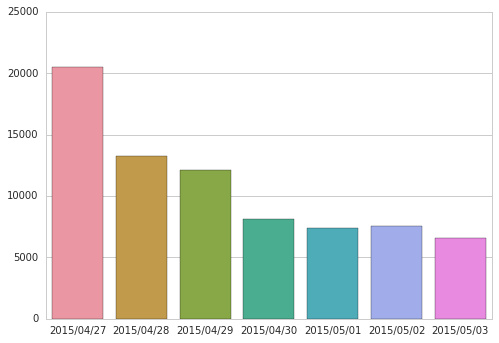

In [22]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.barplot(target_day_list, day_access_list)